## 우버 서비스의 공항, 도시의 수요 공급 gap

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from numpy import median
import seaborn as sns
sns.set_style("whitegrid")
import calendar
import datetime

In [56]:
uber = pd.read_csv("Uber Request Data Original .csv")
print(uber.info())
uber.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB
None


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


## Trip Status of all requests

In [57]:
statuscount = uber[["Request id", "Status"]].groupby("Status").count()
statuscount

,Request id
Status,
Cancelled,1264
No Cars Available,2650
Trip Completed,2831


### Missing Data Check

-Driver id 컬럼은 2650개의 결측치가 있음 이 값은 위의 No Cars Available 의 여행상태 값이랑 같기 때문에 누락된 값이 없음.
-Drop Timestamp 값 3914 의 결측치가 생긴거고 이는 No Cars Available + Cancelled = 3914 의 총합임


In [58]:
uber.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a129ba8>],
      dtype=object)

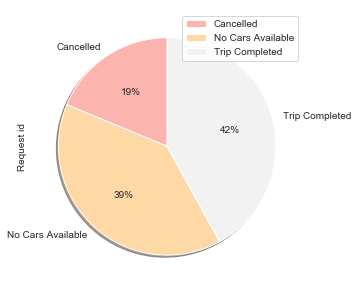

In [59]:
uber[["Request id","Status"]].groupby("Status").count().plot(kind="pie",subplots="True",autopct='%1.0f%%', shadow=True, startangle=90, figsize=[5,5],colormap="Pastel1")

-수요와 공급의 격차가 엄청 큼
-총 여행 요청중 42% 만 완료되고 있음
-운잔자가 취소한 총 19% 의 여행이 있음
-사용불가로 인해 거절된 요청이 39%
따라서 더 큰 문제는 자동차를 이용할 수 없고 요청이 어디에서 왔는지, 공항 또는 도시에 따라 해결해야하는 문제임
Airpot to City and City to Aiport

In [60]:
reqtype=uber[['Request id','Status','Pickup point' ]].groupby(['Pickup point','Status']).count()

reqtype.head()

Request id
Pickup point Status                       
Airport      Cancelled                 198
             No Cars Available        1713
             Trip Completed           1327
City         Cancelled                1066
             No Cars Available         937

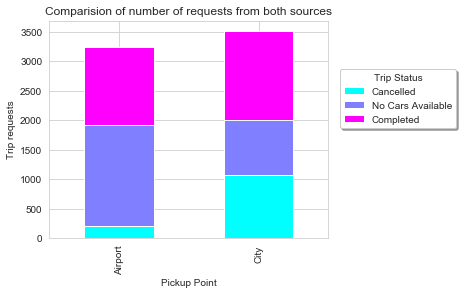

In [61]:
#stack이 (위에서 아래로 길게, 높게) 쌓는 것이면, 
#unstack은 쌓은 것을 옆으로 늘어놓는것(왼쪽에서 오른쪽으로 넓게) 라고 연상이 될 것입니다.

reqtype.unstack().plot(kind='bar', stacked=True, figsize=[5,4], colormap='cool')
plt.xlabel("Pickup Point")
plt.ylabel("Trip requests")
plt.title('Comparision of number of requests from both sources')
plt.legend(title='Trip Status',loc='upper center', bbox_to_anchor=(1.25, 0.8), shadow=True, ncol=1, labels=['Cancelled', 'No Cars Available', 'Completed'])

## Visualising percentage of trips for each status from Airport to city and city to airport

In [62]:
percentgap = reqtype.unstack()
percentgap

Request id                                 
Status        Cancelled No Cars Available Trip Completed
Pickup point                                            
Airport             198              1713           1327
City               1066               937           1504

### airport, city 각각의 캔슬 비율 

In [63]:
#axis = 0 은 열계산
#axis = 1 은 행계산
#df.iloc[[행],[열]] # Data의 행 번호 활용, integer만 가능
percentgap['Cancel%'] = percentgap['Request id']['Cancelled']/percentgap.iloc[0:,:3].sum(axis=1)*100
percentgap['Cancel%'] 

Pickup point
Airport     6.114886
City       30.396350
Name: Cancel%, dtype: float64

In [64]:
percentgap['NoCarsAvailable%'] = percentgap['Request id']['No Cars Available']/percentgap.iloc[0:,:3].sum(axis=1)*100
percentgap['NoCarsAvailable%']

Pickup point
Airport    52.903027
City       26.717993
Name: NoCarsAvailable%, dtype: float64

In [65]:
percentgap['TripCompleted%'] = percentgap['Request id']['Trip Completed'] / percentgap.iloc[0:,:3].sum(axis=1) * 100
percentgap['TripCompleted%']

Pickup point
Airport    40.982088
City       42.885657
Name: TripCompleted%, dtype: float64

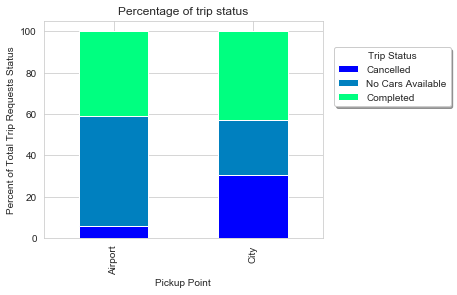

In [66]:
percentgap.iloc[0:,3:].plot(kind='bar', stacked = True, figsize=[5,4], colormap = 'winter')
plt.xlabel('Pickup Point')
plt.ylabel('Percent of Total Trip Requests Status')
plt.title('Percentage of trip status')
plt.legend(title='Trip Status', loc='upper center', bbox_to_anchor=(1.25,0.9), shadow=True, ncol=1, labels=['Cancelled', 'No Cars Available', 'Completed'])

더 문제가 있는 픽업 지점은 도시보단 공항 59%(차량 이용 불가 53% , 취소 6%) 도시는 57%(차량 이용 불가27%, 취소 30% )

## 요청 타임 스탬프에서 파생 Metric 만들기

### 여행 요청 시간, 요일 타임 슬롯 : 이른 아침, 월요일, 오후, 저녁, 밤 및 심야

In [67]:
uber['Request timestamp'] = pd.to_datetime(uber['Request timestamp'])

In [68]:
uber['reqhour'] = uber['Request timestamp'].dt.hour
uber['Day'] = uber['Request timestamp'].apply(lambda x:datetime.datetime.strftime(x, '%A'))
uber.head()

#strftime() : 문자열 반환
#datatime 패키지에서는 날짜와 시간을 함께 저장하는 datetime 클래스, 날짜만 저장하는 date 클래스, 시간만 저장하는 time 클래스, 시간 구간 정보를 저장하는 timedelta 클래스 등을 제공한다.

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,reqhour,Day
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,11/7/2016 13:00,11,Monday
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,11/7/2016 18:47,17,Monday
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,12/7/2016 9:58,9,Wednesday
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,12/7/2016 22:03,21,Wednesday
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,13-07-2016 09:25:47,8,Wednesday


### 요일별 days of the week

In [69]:
tripday = uber[["Request id", "Status", "Day"]].groupby(["Day","Status"]).count().unstack()

In [70]:
tripday

Request id                                 
Status     Cancelled No Cars Available Trip Completed
Day                                                  
Friday           240               580            561
Monday           262               504            601
Thursday         252               571            530
Wednesday        510               995           1139

<Figure size 1080x720 with 0 Axes>

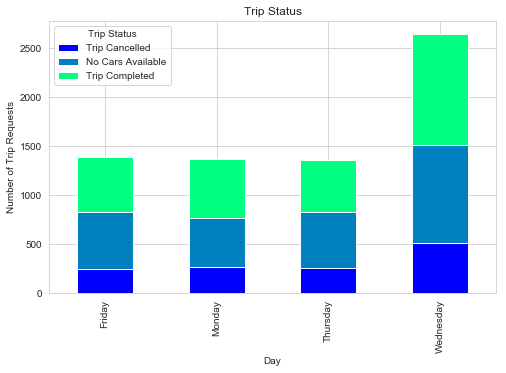

In [71]:
plt.figure(figsize=(15,10))
tripday.plot(kind='bar', stacked=True, figsize=[8,5], legend=True, colormap="winter")
plt.xlabel("Day")
plt.ylabel("Number of Trip Requests")
plt.title("Trip Status")
plt.legend(title="Trip Status", loc ="upper left", labels = ['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()



### 요일별 : 도시, 공항 비교

In [72]:
timeslots = uber[["Request id", "Status", "Day", "Pickup point"]].groupby(["Day", "Pickup point", "Status"]).count()

In [73]:
timeslots

Request id
Day       Pickup point Status                       
Friday    Airport      Cancelled                  31
                       No Cars Available         330
                       Trip Completed            268
          City         Cancelled                 209
                       No Cars Available         250
                       Trip Completed            293
Monday    Airport      Cancelled                  42
                       No Cars Available         338
                       Trip Completed            281
          City         Cancelled                 220
                       No Cars Available         166
                       Trip Completed            320
Thursday  Airport      Cancelled                  32
                       No Cars Available         378
                       Trip Completed            191
          City         Cancelled                 220
                       No Cars Available         193
                       Trip Completed            339
Wednesday Airport      Cancelled                  93
                       No Cars Available         667
                       Trip Completed            587
          City         Cancelled                 417
                       No Cars Available         328
                       Trip Completed            552

<Figure size 1080x720 with 0 Axes>

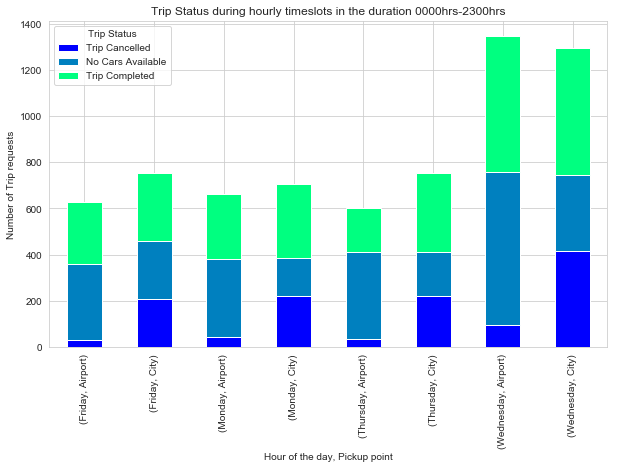

In [74]:
plt.figure(figsize=(15,10))
timeslots.unstack().plot(kind='bar', stacked=True, figsize=[10,6], legend=True, colormap='winter')
plt.xlabel("Hour of the day, Pickup point")
plt.ylabel("Number of Trip requests")
plt.title("Trip Status during hourly timeslots in the duration 0000hrs-2300hrs")
plt.legend(title = 'Trip Status', loc='upper left', labels=['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()

### 시간 : 모든 여행 모든 픽업 지점 합산

In [75]:
timeslots = uber[["Request id", "Status", "reqhour"]].groupby(["reqhour", "Status"]).count()
timeslots

Request id
reqhour Status                       
0       Cancelled                   3
        No Cars Available          56
        Trip Completed             40
1       Cancelled                   4
        No Cars Available          56
        Trip Completed             25
2       Cancelled                   5
        No Cars Available          57
        Trip Completed             37
3       Cancelled                   2
        No Cars Available          56
        Trip Completed             34
4       Cancelled                  51
        No Cars Available          74
        Trip Completed             78
5       Cancelled                 176
        No Cars Available          84
        Trip Completed            185
6       Cancelled                 145
        No Cars Available          86
        Trip Completed            167
7       Cancelled                 169
        No Cars Available          63
        Trip Completed            174
8       Cancelled                 178
        No Cars Available          90
        Trip Completed            155
9       Cancelled                 175
        No Cars Available          83
        Trip Completed            173
...                               ...
14      Cancelled                  11
        No Cars Available          37
        Trip Completed             88
15      Cancelled                  21
        No Cars Available          48
        Trip Completed            102
16      Cancelled                  22
        No Cars Available          46
        Trip Completed             91
17      Cancelled                  35
        No Cars Available         232
        Trip Completed            151
18      Cancelled                  24
        No Cars Available         322
        Trip Completed            164
19      Cancelled                  24
        No Cars Available         283
        Trip Completed            166
20      Cancelled                  41
        No Cars Available         290
        Trip Completed            161
21      Cancelled                  42
        No Cars Available         265
        Trip Completed            142
22      Cancelled                  12
        No Cars Available         138
        Trip Completed            154
23      Cancelled                  10
        No Cars Available          81
        Trip Completed            103

[72 rows x 1 columns]

<Figure size 1080x720 with 0 Axes>

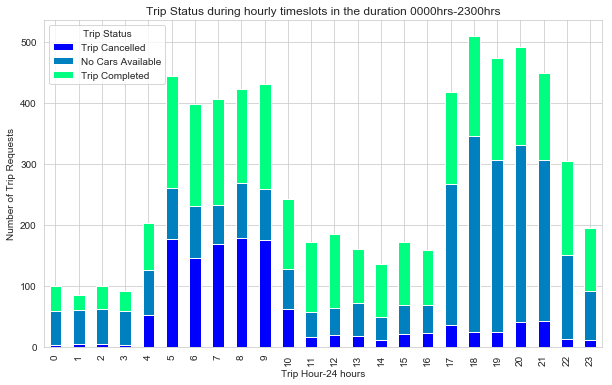

In [76]:
plt.figure(figsize = (15,10))
timeslots.unstack().plot(kind='bar', stacked=True, figsize=[10,6], legend=True, colormap='winter')
plt.xlabel("Trip Hour-24 hours")
plt.ylabel("Number of Trip Requests")
plt.title("Trip Status during hourly timeslots in the duration 0000hrs-2300hrs")
plt.legend(title = "Trip Status", loc = "upper left", labels = ['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()

### 시간 : 공항과 도시 비교 차트

In [77]:
timeslots=uber[["Request id", "Status", "reqhour", "Pickup point"]].groupby(["reqhour", "Pickup point", "Status"]).count()
timeslots

Request id
reqhour Pickup point Status                       
0       Airport      No Cars Available          30
                     Trip Completed             23
        City         Cancelled                   3
                     No Cars Available          26
                     Trip Completed             17
1       Airport      No Cars Available          29
                     Trip Completed             13
        City         Cancelled                   4
                     No Cars Available          27
                     Trip Completed             12
2       Airport      No Cars Available          25
                     Trip Completed             16
        City         Cancelled                   5
                     No Cars Available          32
                     Trip Completed             21
3       Airport      No Cars Available          30
                     Trip Completed             15
        City         Cancelled                   2
                     No Cars Available          26
                     Trip Completed             19
4       Airport      Cancelled                   2
                     No Cars Available          34
                     Trip Completed             36
        City         Cancelled                  49
                     No Cars Available          40
                     Trip Completed             42
5       Airport      Cancelled                   4
                     No Cars Available           3
                     Trip Completed             85
        City         Cancelled                 172
...                                            ...
18      City         Trip Completed             83
19      Airport      Cancelled                  15
                     No Cars Available         268
                     Trip Completed             83
        City         Cancelled                   9
                     No Cars Available          15
                     Trip Completed             83
20      Airport      Cancelled                  29
                     No Cars Available         275
                     Trip Completed             74
        City         Cancelled                  12
                     No Cars Available          15
                     Trip Completed             87
21      Airport      Cancelled                  28
                     No Cars Available         254
                     Trip Completed             61
        City         Cancelled                  14
                     No Cars Available          11
                     Trip Completed             81
22      Airport      Cancelled                   3
                     No Cars Available         100
                     Trip Completed             80
        City         Cancelled                   9
                     No Cars Available          38
                     Trip Completed             74
23      Airport      No Cars Available          36
                     Trip Completed             62
        City         Cancelled                  10
                     No Cars Available          45
                     Trip Completed             41

[139 rows x 1 columns]

<Figure size 1080x720 with 0 Axes>

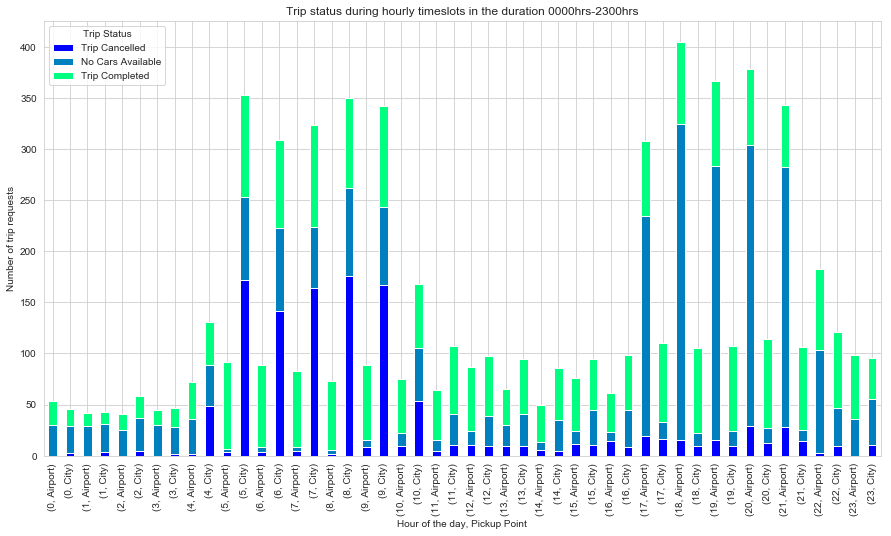

In [78]:
plt.figure(figsize=(15,10))
timeslots.unstack().plot(kind='bar', stacked = True, figsize=[15,8], legend = True, colormap = 'winter')
plt.xlabel("Hour of the day, Pickup Point")
plt.ylabel("Number of trip requests")
plt.title("Trip status during hourly timeslots in the duration 0000hrs-2300hrs")
plt.legend(title = 'Trip Status', loc = 'upper left', labels=['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()

가장 문제가 되는 시간대는 5-9시 , 17-21시
400 회 이상의 요청 및 약 150 완료 중. 이 타임 슬롯에는 70-80 %의 공급 수요 차이가 있음

## create dataframe of trip status value counts for city and airport 

In [79]:
sd = uber[["Request id", "Status", "reqhour", "Pickup point"]].groupby(["reqhour", "Pickup point", "Status"]).count().unstack()

In [80]:
sd

Request id                                 
Status                Cancelled No Cars Available Trip Completed
reqhour Pickup point                                            
0       Airport             NaN              30.0           23.0
        City                3.0              26.0           17.0
1       Airport             NaN              29.0           13.0
        City                4.0              27.0           12.0
2       Airport             NaN              25.0           16.0
        City                5.0              32.0           21.0
3       Airport             NaN              30.0           15.0
        City                2.0              26.0           19.0
4       Airport             2.0              34.0           36.0
        City               49.0              40.0           42.0
5       Airport             4.0               3.0           85.0
        City              172.0              81.0          100.0
6       Airport             4.0               4.0           81.0
        City              141.0              82.0           86.0
7       Airport             5.0               3.0           75.0
        City              164.0              60.0           99.0
8       Airport             2.0               4.0           67.0
        City              176.0              86.0           88.0
9       Airport             8.0               7.0           74.0
        City              167.0              76.0           99.0
10      Airport             9.0              13.0           53.0
        City               53.0              52.0           63.0
11      Airport             5.0              10.0           49.0
        City               10.0              31.0           66.0
12      Airport            10.0              14.0           63.0
        City                9.0              30.0           58.0
13      Airport             9.0              21.0           35.0
        City                9.0              32.0           54.0
14      Airport             6.0               7.0           37.0
        City                5.0              30.0           51.0
15      Airport            11.0              13.0           52.0
        City               10.0              35.0           50.0
16      Airport            14.0               9.0           38.0
        City                8.0              37.0           53.0
17      Airport            19.0             215.0           74.0
        City               16.0              17.0           77.0
18      Airport            15.0             309.0           81.0
        City                9.0              13.0           83.0
19      Airport            15.0             268.0           83.0
        City                9.0              15.0           83.0
20      Airport            29.0             275.0           74.0
        City               12.0              15.0           87.0
21      Airport            28.0             254.0           61.0
        City               14.0              11.0           81.0
22      Airport             3.0             100.0           80.0
        City                9.0              38.0           74.0
23      Airport             NaN              36.0           62.0
        City               10.0              45.0           41.0

In [81]:
# fill nan values with 0 because Nan is for 0 count in respective trip status
supdem = sd.fillna(0)
supdem

Request id                                 
Status                Cancelled No Cars Available Trip Completed
reqhour Pickup point                                            
0       Airport             0.0              30.0           23.0
        City                3.0              26.0           17.0
1       Airport             0.0              29.0           13.0
        City                4.0              27.0           12.0
2       Airport             0.0              25.0           16.0
        City                5.0              32.0           21.0
3       Airport             0.0              30.0           15.0
        City                2.0              26.0           19.0
4       Airport             2.0              34.0           36.0
        City               49.0              40.0           42.0
5       Airport             4.0               3.0           85.0
        City              172.0              81.0          100.0
6       Airport             4.0               4.0           81.0
        City              141.0              82.0           86.0
7       Airport             5.0               3.0           75.0
        City              164.0              60.0           99.0
8       Airport             2.0               4.0           67.0
        City              176.0              86.0           88.0
9       Airport             8.0               7.0           74.0
        City              167.0              76.0           99.0
10      Airport             9.0              13.0           53.0
        City               53.0              52.0           63.0
11      Airport             5.0              10.0           49.0
        City               10.0              31.0           66.0
12      Airport            10.0              14.0           63.0
        City                9.0              30.0           58.0
13      Airport             9.0              21.0           35.0
        City                9.0              32.0           54.0
14      Airport             6.0               7.0           37.0
        City                5.0              30.0           51.0
15      Airport            11.0              13.0           52.0
        City               10.0              35.0           50.0
16      Airport            14.0               9.0           38.0
        City                8.0              37.0           53.0
17      Airport            19.0             215.0           74.0
        City               16.0              17.0           77.0
18      Airport            15.0             309.0           81.0
        City                9.0              13.0           83.0
19      Airport            15.0             268.0           83.0
        City                9.0              15.0           83.0
20      Airport            29.0             275.0           74.0
        City               12.0              15.0           87.0
21      Airport            28.0             254.0           61.0
        City               14.0              11.0           81.0
22      Airport             3.0             100.0           80.0
        City                9.0              38.0           74.0
23      Airport             0.0              36.0           62.0
        City               10.0              45.0           41.0

In [82]:
cancel = round(supdem["Request id"]["Cancelled"] / supdem.sum(axis = 1) * 100)
nocars = round(supdem["Request id"]["No Cars Available"] / supdem.sum(axis=1) * 100)
tripcomp = round(supdem["Request id"]["Trip Completed"] / supdem.sum(axis = 1) * 100)

In [83]:
dfs = [supdem, cancel, nocars, tripcomp]
supdemgap = pd.concat(dfs, axis = 1)
supdemgap

(Request id, Cancelled)  \
reqhour Pickup point                            
0       Airport                           0.0   
        City                              3.0   
1       Airport                           0.0   
        City                              4.0   
2       Airport                           0.0   
        City                              5.0   
3       Airport                           0.0   
        City                              2.0   
4       Airport                           2.0   
        City                             49.0   
5       Airport                           4.0   
        City                            172.0   
6       Airport                           4.0   
        City                            141.0   
7       Airport                           5.0   
        City                            164.0   
8       Airport                           2.0   
        City                            176.0   
9       Airport                           8.0   
        City                            167.0   
10      Airport                           9.0   
        City                             53.0   
11      Airport                           5.0   
        City                             10.0   
12      Airport                          10.0   
        City                              9.0   
13      Airport                           9.0   
        City                              9.0   
14      Airport                           6.0   
        City                              5.0   
15      Airport                          11.0   
        City                             10.0   
16      Airport                          14.0   
        City                              8.0   
17      Airport                          19.0   
        City                             16.0   
18      Airport                          15.0   
        City                              9.0   
19      Airport                          15.0   
        City                              9.0   
20      Airport                          29.0   
        City                             12.0   
21      Airport                          28.0   
        City                             14.0   
22      Airport                           3.0   
        City                              9.0   
23      Airport                           0.0   
        City                             10.0   

                      (Request id, No Cars Available)  \
reqhour Pickup point                                    
0       Airport                                  30.0   
        City                                     26.0   
1       Airport                                  29.0   
        City                                     27.0   
2       Airport                                  25.0   
        City                                     32.0   
3       Airport                                  30.0   
        City                                     26.0   
4       Airport                                  34.0   
        City                                     40.0   
5       Airport                                   3.0   
        City                                     81.0   
6       Airport                                   4.0   
        City                                     82.0   
7       Airport                                   3.0   
        City                                     60.0   
8       Airport                                   4.0   
        City                                     86.0   
9       Airport                                   7.0   
        City                                     76.0   
10      Airport                                  13.0   
        City                                     52.0   
11      Airport                                  10.0   
        City                                     31.0   
12      Airport                                  14.0   
        City                    

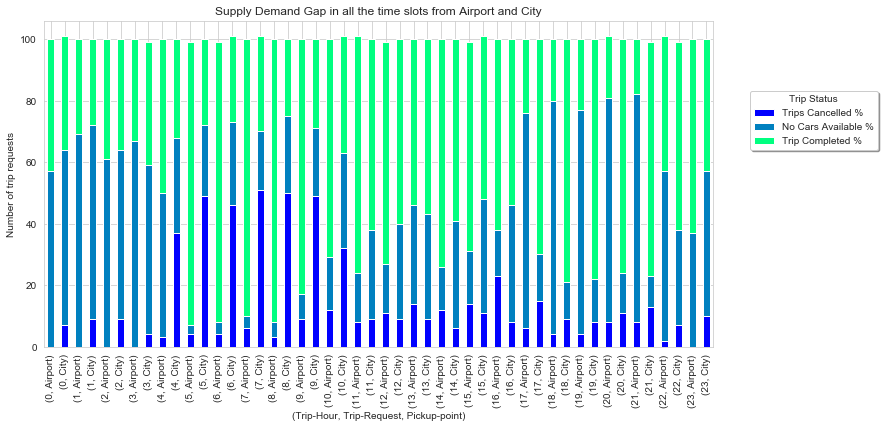

In [84]:
supdemgap.columns=['Cancelled', 'No Cars Available', 'Trip Completed', "%cancelled", "%NoCarsAvail", "%TripCompleted"]
supdemgap.iloc[0:,3:].plot(kind='bar', stacked = True, figsize=[12,6], colormap = "winter")
plt.xlabel("(Trip-Hour, Trip-Request, Pickup-point)")
plt.ylabel("Number of trip requests")
plt.title("Supply Demand Gap in all the time slots from Airport and City")
plt.legend(title='Trip Status', loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1, labels=['Trips Cancelled %', 'No Cars Available %', 'Trip Completed %'])

## City to Airport : hours of the day

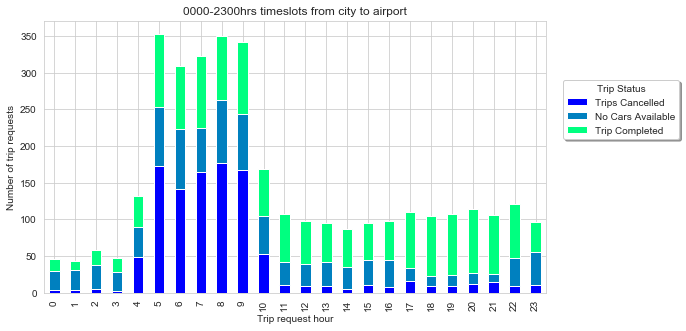

In [85]:
n = uber[["Request id", "Status", "reqhour", "Pickup point"]].groupby(["reqhour", "Pickup point", "Status"]).count()
citysupdemgap = n.unstack().loc[sd.index.get_level_values("Pickup point")=="City"].reset_index(level = "Pickup point", drop = True)
airportsupdemgap = n.unstack().loc[sd.index.get_level_values("Pickup point")=="Airport"].reset_index(level = "Pickup point", drop = True)
citysupdemgap.plot(kind="bar", stacked = True, figsize=[9,5], colormap="winter")
plt.xlabel("Trip request hour")
plt.ylabel("Number of trip requests")
plt.title("0000-2300hrs timeslots from city to airport")
plt.legend(title = 'Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trip Completed'], loc='upper center', bbox_to_anchor = (1.15,0.8), shadow = True, ncol = 1)

## Trip Status Percentage - City to Airport - hours of the day

In [86]:
timepickcity=supdemgap.loc[supdemgap.index.get_level_values("Pickup point")=="City"].iloc[0:,3:].reset_index(level="Pickup point", drop=True)

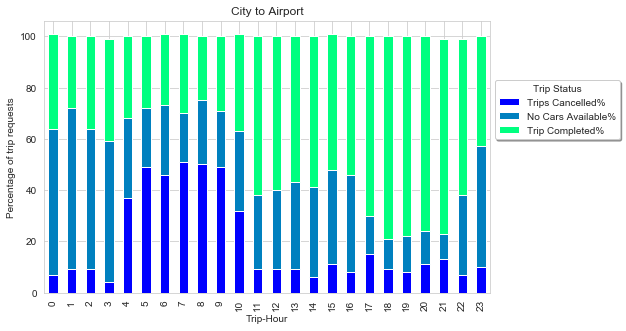

In [87]:
timepickcity.plot(kind='bar', stacked=True, figsize=[8,5], colormap="winter")
plt.xlabel("Trip-Hour")
plt.ylabel("Percentage of trip requests")
plt.title("City to Airport")
plt.legend(title='Trip Status', labels=['Trips Cancelled%', 'No Cars Available%', 'Trip Completed%'], loc='upper center', bbox_to_anchor=(1.15,0.8), shadow=True, ncol=1)

### Trip Status Count - Airport to City - hours of the day

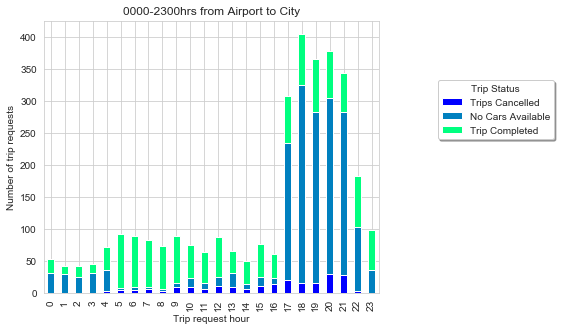

In [88]:
airportsupdemgap.plot(kind='bar', stacked=True, figsize=[6,5], colormap="winter")
plt.xlabel('Trip request hour')
plt.ylabel('Number of trip requests')
plt.title('0000-2300hrs from Airport to City')
plt.legend(title='Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trip Completed'], loc='upper center', bbox_to_anchor=(1.35,0.8), shadow=True, ncol=1)

### Trip Status Percentage - Airport to City - hours of the day

In [89]:
timepickair = supdemgap.loc[supdemgap.index.get_level_values("Pickup point")=="Airport"].iloc[0:,3:].reset_index(level="Pickup point", drop = True)
timepickair

,%cancelled,%NoCarsAvail,%TripCompleted
reqhour,,,
0,0.0,57.0,43.0
1,0.0,69.0,31.0
2,0.0,61.0,39.0
3,0.0,67.0,33.0
4,3.0,47.0,50.0
5,4.0,3.0,92.0
6,4.0,4.0,91.0
7,6.0,4.0,90.0
8,3.0,5.0,92.0


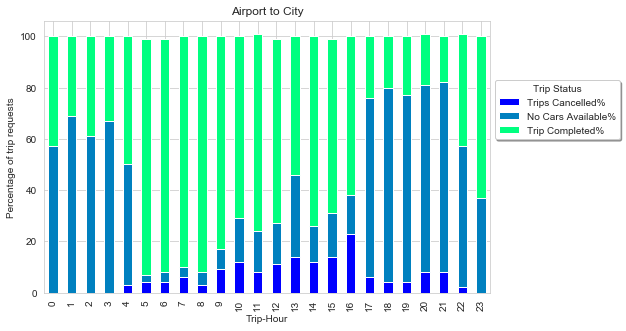

In [90]:
timepickair.plot(kind='bar', colormap="winter",stacked=True, figsize=[8,5], title = 'Airport to City')
plt.xlabel("Trip-Hour")
plt.ylabel("Percentage of trip requests")
plt.legend(title='Trip Status', labels=['Trips Cancelled%', 'No Cars Available%', 'Trip Completed%'],loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)

#legend 가 그래프를 가릴 경우 bbox_to_anchor 를 써서 위치 바꿀 수 있음

## Timeslots 
total count from Both Pickup points together Trip Status Count - Early Moring to Late night Slot

In [93]:
morn5to9 = pd.DataFrame(sd.loc[5:8].sum())
morn9to12 = pd.DataFrame(sd.loc[9:11].sum())
afternoon1to5 = pd.DataFrame(sd.loc[12:16].sum())
evening5to10 = pd.DataFrame(sd.loc[17:21].sum())
night10to12 = pd.DataFrame(sd.loc[22:23].sum())
midnight12to5am = pd.DataFrame(sd.loc[0:4].sum())

In [94]:
slots=pd.concat([morn5to9, morn9to12, afternoon1to5, evening5to10, night10to12, midnight12to5am], axis=1)

In [95]:
slots

0      0      0       0      0      0
           Status                                                      
Request id Cancelled          668.0  252.0   91.0   166.0   22.0   65.0
           No Cars Available  323.0  189.0  228.0  1392.0  219.0  299.0
           Trip Completed     681.0  404.0  491.0   784.0  257.0  214.0

In [96]:
slots.columns=['morn5to9', 'morn9to12', 'afternoon1to5', 'evening5to10pm', 'night10to12', 'midnight12to5am']

In [97]:
slots

morn5to9  morn9to12  afternoon1to5  \
           Status                                                  
Request id Cancelled             668.0      252.0           91.0   
           No Cars Available     323.0      189.0          228.0   
           Trip Completed        681.0      404.0          491.0   

                              evening5to10pm  night10to12  midnight12to5am  
           Status                                                           
Request id Cancelled                   166.0         22.0             65.0  
           No Cars Available          1392.0        219.0            299.0  
           Trip Completed              784.0        257.0            214.0

In [98]:
slots.reset_index(inplace = True)
slots

,level_0,Status,morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am
0,Request id,Cancelled,668.0,252.0,91.0,166.0,22.0,65.0
1,Request id,No Cars Available,323.0,189.0,228.0,1392.0,219.0,299.0
2,Request id,Trip Completed,681.0,404.0,491.0,784.0,257.0,214.0


In [99]:
slots.drop("level_0", axis=1, inplace=True)
slots

,Status,morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am
0,Cancelled,668.0,252.0,91.0,166.0,22.0,65.0
1,No Cars Available,323.0,189.0,228.0,1392.0,219.0,299.0
2,Trip Completed,681.0,404.0,491.0,784.0,257.0,214.0


In [100]:
slots.set_index("Status", inplace=True)
slots

,morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am
Status,,,,,,
Cancelled,668.0,252.0,91.0,166.0,22.0,65.0
No Cars Available,323.0,189.0,228.0,1392.0,219.0,299.0
Trip Completed,681.0,404.0,491.0,784.0,257.0,214.0


In [101]:
gap = slots.T
gap

Status,Cancelled,No Cars Available,Trip Completed
morn5to9,668.0,323.0,681.0
morn9to12,252.0,189.0,404.0
afternoon1to5,91.0,228.0,491.0
evening5to10pm,166.0,1392.0,784.0
night10to12,22.0,219.0,257.0
midnight12to5am,65.0,299.0,214.0


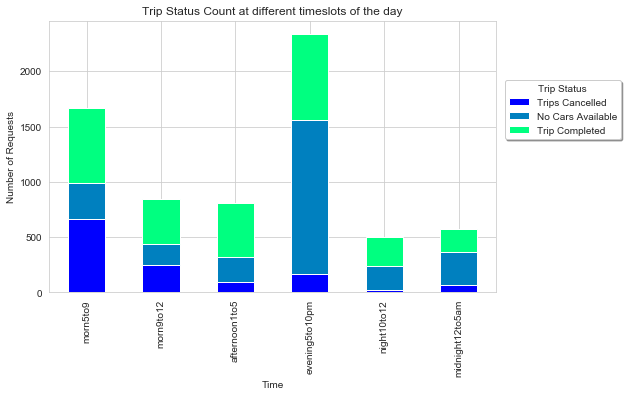

In [102]:
gap.plot(kind='bar', stacked=True, figsize=[8,5], colormap="winter")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("Trip Status Count at different timeslots of the day")
plt.legend(title='Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trip Completed'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)

-  누적 100% 로 확인해보자

In [103]:
total=slots.sum()
cancel=round((slots.loc["Cancelled"]/total)*100)
nocars=round((slots.loc["No Cars Available"]/total)*100)
tripcomp=round((slots.loc["Trip Completed"]/total)*100)
fail=slots.iloc[:2].sum()
failperc=round((fail/total)*100)
supply_dem_gap=pd.concat([gap,pd.DataFrame(columns =["%cancelled", "%NoCarsAvail", "%TripCompleted","%Failed_req",
           "failed requests","total_requests"])])
supply_dem_gap["%cancelled"]=cancel
supply_dem_gap["%NoCarsAvail"]=nocars
supply_dem_gap["%TripCompleted"]=tripcomp
supply_dem_gap["%Failed_req"]=failperc
supply_dem_gap["failed requests"]=fail
supply_dem_gap["total_requests"]=total

supply_dem_gap

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,%Failed_req,%NoCarsAvail,%TripCompleted,%cancelled,Cancelled,No Cars Available,Trip Completed,failed requests,total_requests
morn5to9,59.0,19.0,41.0,40.0,668.0,323.0,681.0,991.0,1672.0
morn9to12,52.0,22.0,48.0,30.0,252.0,189.0,404.0,441.0,845.0
afternoon1to5,39.0,28.0,61.0,11.0,91.0,228.0,491.0,319.0,810.0
evening5to10pm,67.0,59.0,33.0,7.0,166.0,1392.0,784.0,1558.0,2342.0
night10to12,48.0,44.0,52.0,4.0,22.0,219.0,257.0,241.0,498.0
midnight12to5am,63.0,52.0,37.0,11.0,65.0,299.0,214.0,364.0,578.0


In [104]:
total

morn5to9           1672.0
morn9to12           845.0
afternoon1to5       810.0
evening5to10pm     2342.0
night10to12         498.0
midnight12to5am     578.0
dtype: float64

In [105]:
slots

,morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am
Status,,,,,,
Cancelled,668.0,252.0,91.0,166.0,22.0,65.0
No Cars Available,323.0,189.0,228.0,1392.0,219.0,299.0
Trip Completed,681.0,404.0,491.0,784.0,257.0,214.0


In [106]:
fail

morn5to9            991.0
morn9to12           441.0
afternoon1to5       319.0
evening5to10pm     1558.0
night10to12         241.0
midnight12to5am     364.0
dtype: float64

In [107]:
gap

Status,Cancelled,No Cars Available,Trip Completed
morn5to9,668.0,323.0,681.0
morn9to12,252.0,189.0,404.0
afternoon1to5,91.0,228.0,491.0
evening5to10pm,166.0,1392.0,784.0
night10to12,22.0,219.0,257.0
midnight12to5am,65.0,299.0,214.0


### Trip Status Percentage - Early Morning to Late night Slots

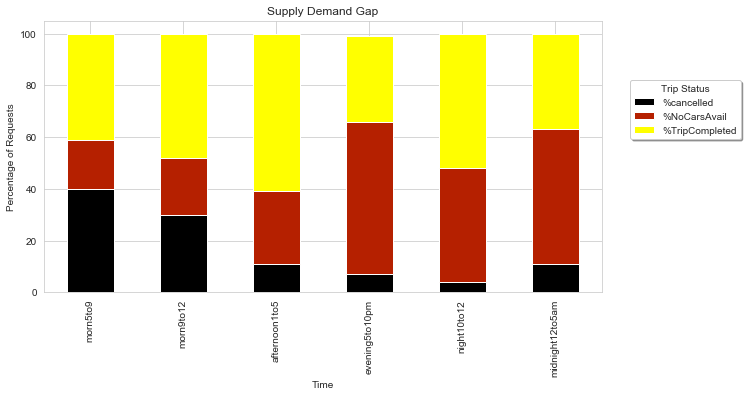

In [108]:
supply_dem_gap[["%cancelled", "%NoCarsAvail", "%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel("Time")
plt.ylabel("Percentage of Requests")
plt.title("Supply Demand Gap")
plt.legend(title='Trip Status', labels=["%cancelled", "%NoCarsAvail", "%TripCompleted"],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)

### Failed and Successful Trip Percentage - Early Morning to Late night Slots

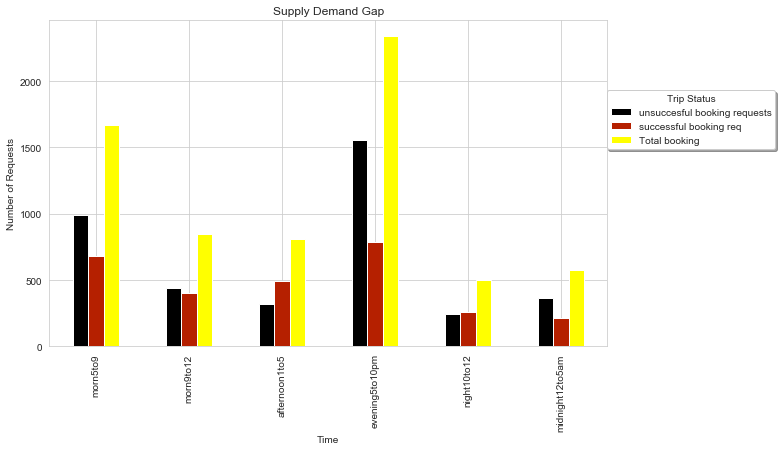

In [109]:
supply_dem_gap[["failed requests","Trip Completed","total_requests"]].plot(kind='bar',figsize=[10,6], colormap="gnuplot")
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.title('Supply Demand Gap')
plt.legend(title='Trip Status', labels=['unsuccesful booking requests', 'successful booking req', 'Total booking'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)


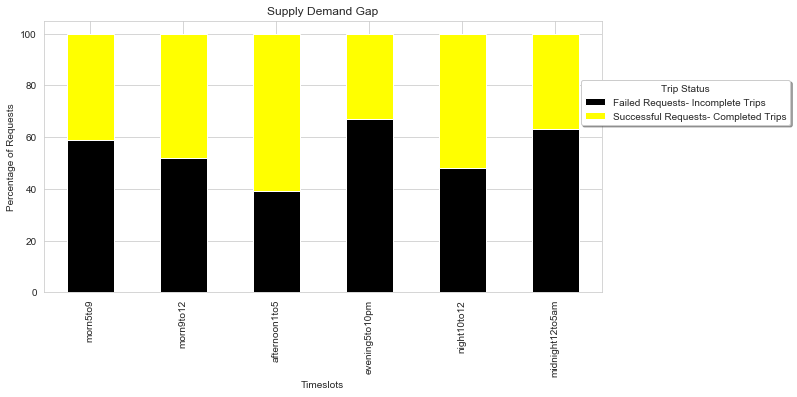

In [110]:
supply_dem_gap[["%Failed_req","%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel("Timeslots")
plt.ylabel("Percentage of Requests")
plt.title("Supply Demand Gap")
plt.legend(title='Trip Status', labels=['Failed Requests- Incomplete Trips', 'Successful Requests- Completed Trips'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)


# Trip Status Count - Time Slots - Airport to City

In [111]:
morn5to9=pd.DataFrame(airportsupdemgap.loc[5:8].sum())
morn9to12=pd.DataFrame(airportsupdemgap.loc[9:11].sum())
afternoon1to5=pd.DataFrame(airportsupdemgap.loc[12:16].sum())
evening5to10pm=pd.DataFrame(airportsupdemgap.loc[17:21].sum())
night10to12=pd.DataFrame(airportsupdemgap.loc[22:23].sum())
midnight12to5am=pd.DataFrame(airportsupdemgap.loc[0:4].sum())

In [112]:
morn5to9

0
           Status                  
Request id Cancelled           15.0
           No Cars Available   14.0
           Trip Completed     308.0

In [113]:
#concat함수로 데이터 프레임끼리 합침(아래의 형식으로 합치면 됨)
slots=pd.concat([morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am], axis=1)
slots

0      0      0       0      0      0
           Status                                                      
Request id Cancelled           15.0   22.0   50.0   106.0    3.0    2.0
           No Cars Available   14.0   30.0   64.0  1321.0  136.0  148.0
           Trip Completed     308.0  176.0  225.0   373.0  142.0  103.0

In [114]:
# 컬럼이름을 설정해주자
slots.columns=["morn5to9","morn9to12","afternoon1to5","evening5to10pm","night10to12","midnight12to5am"]
slots

morn5to9  morn9to12  afternoon1to5  \
           Status                                                  
Request id Cancelled              15.0       22.0           50.0   
           No Cars Available      14.0       30.0           64.0   
           Trip Completed        308.0      176.0          225.0   

                              evening5to10pm  night10to12  midnight12to5am  
           Status                                                           
Request id Cancelled                   106.0          3.0              2.0  
           No Cars Available          1321.0        136.0            148.0  
           Trip Completed              373.0        142.0            103.0

In [115]:
# 인덱스 설정 다시 해주고
slots.reset_index(inplace=True)
slots

,level_0,Status,morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am
0,Request id,Cancelled,15.0,22.0,50.0,106.0,3.0,2.0
1,Request id,No Cars Available,14.0,30.0,64.0,1321.0,136.0,148.0
2,Request id,Trip Completed,308.0,176.0,225.0,373.0,142.0,103.0


In [116]:
#level_0 인덱스는 필요없으니 버리고 State로 변경해주자
slots.drop('level_0', axis=1, inplace = True)
slots.set_index('Status', inplace = True)
slots

,morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am
Status,,,,,,
Cancelled,15.0,22.0,50.0,106.0,3.0,2.0
No Cars Available,14.0,30.0,64.0,1321.0,136.0,148.0
Trip Completed,308.0,176.0,225.0,373.0,142.0,103.0


In [117]:
# 이제 새로운 변수에 Transformation 
gap = slots.T
gap

Status,Cancelled,No Cars Available,Trip Completed
morn5to9,15.0,14.0,308.0
morn9to12,22.0,30.0,176.0
afternoon1to5,50.0,64.0,225.0
evening5to10pm,106.0,1321.0,373.0
night10to12,3.0,136.0,142.0
midnight12to5am,2.0,148.0,103.0


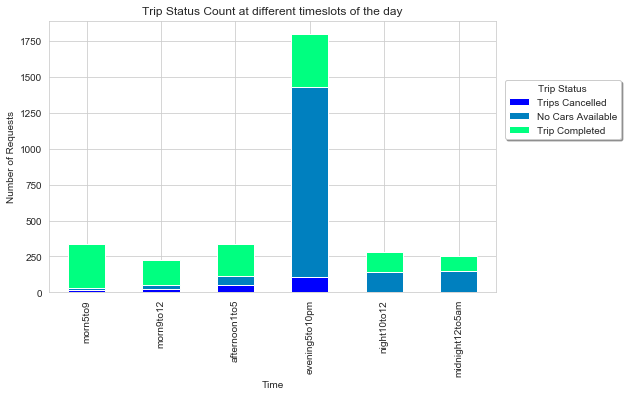

In [118]:
gap.plot(kind='bar', stacked = True, figsize=[8,5], colormap = 'winter')
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("Trip Status Count at different timeslots of the day")
plt.legend(title = 'Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trip Completed'], loc='upper center', bbox_to_anchor=(1.15,0.8), shadow = True, ncol=1)

In [119]:
#위에서 연산한 변수들을 gap 데이터 프레임 옆에다 데이터프레임으로 변환해서 붙이자

total=slots.sum()
cancel=round((slots.loc["Cancelled"]/total)*100)
nocars=round((slots.loc["No Cars Available"]/total)*100)
tripcomp=round((slots.loc["Trip Completed"]/total)*100)
fail=slots.iloc[:2].sum()
failperc=round((fail/total)*100)
supply_dem_gap=pd.concat([gap,pd.DataFrame(columns =["%cancelled", "%NoCarsAvail", "%TripCompleted","%Failed_req",
           "failed requests","total_requests"])])
supply_dem_gap["%cancelled"]=cancel
supply_dem_gap["%NoCarsAvail"]=nocars
supply_dem_gap["%TripCompleted"]=tripcomp
supply_dem_gap["%Failed_req"]=failperc
supply_dem_gap["failed requests"]=fail
supply_dem_gap["total_requests"]=total

supply_dem_gap

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,%Failed_req,%NoCarsAvail,%TripCompleted,%cancelled,Cancelled,No Cars Available,Trip Completed,failed requests,total_requests
morn5to9,9.0,4.0,91.0,4.0,15.0,14.0,308.0,29.0,337.0
morn9to12,23.0,13.0,77.0,10.0,22.0,30.0,176.0,52.0,228.0
afternoon1to5,34.0,19.0,66.0,15.0,50.0,64.0,225.0,114.0,339.0
evening5to10pm,79.0,73.0,21.0,6.0,106.0,1321.0,373.0,1427.0,1800.0
night10to12,49.0,48.0,51.0,1.0,3.0,136.0,142.0,139.0,281.0
midnight12to5am,59.0,58.0,41.0,1.0,2.0,148.0,103.0,150.0,253.0


### Trip Status Percentage - Early Morning to Late night Slots

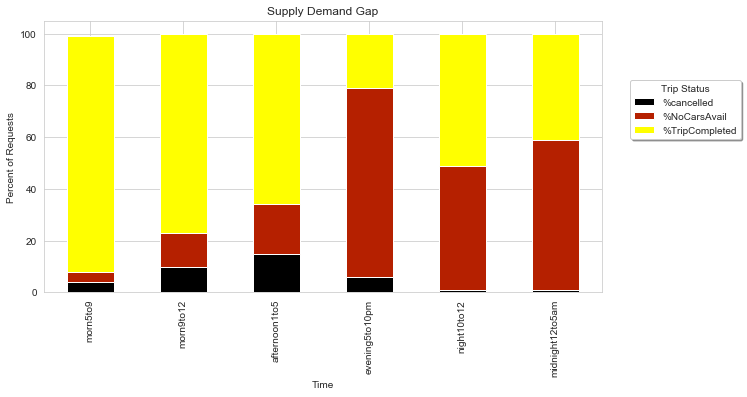

In [120]:
supply_dem_gap[["%cancelled", "%NoCarsAvail", "%TripCompleted"]].plot(kind='bar',stacked=True,figsize=[10,5], colormap="gnuplot")
plt.xlabel('Time')
plt.ylabel('Percent of Requests')
plt.title('Supply Demand Gap')
plt.legend(title='Trip Status', labels = ['%cancelled', '%NoCarsAvail','%TripCompleted'], loc = 'upper center', bbox_to_anchor = (1.15,0.8), shadow=True, ncol=1)

### Failed and Successful Trip Percentage - Early Morning to Late night Slots Failed and Successful Count

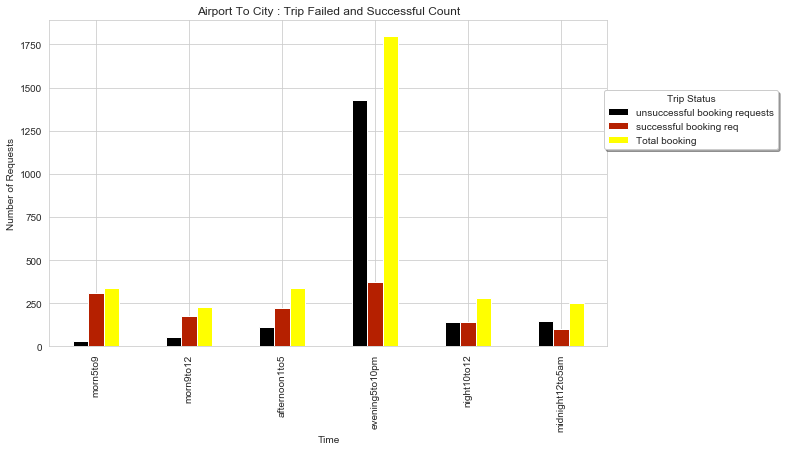

In [121]:
supply_dem_gap[['failed requests', "Trip Completed", "total_requests"]].plot(kind="bar", figsize=[10,6], colormap='gnuplot')
plt.xlabel('Time')
plt.ylabel("Number of Requests")
plt.title("Airport To City : Trip Failed and Successful Count")
plt.legend(title = 'Trip Status', labels = ['unsuccessful booking requests', 'successful booking req', 'Total booking'], loc = 'upper center', bbox_to_anchor=(1.15,0.8), shadow=True, ncol=1)

- Observation : City to Airport Average Supply-Demand gap of 57% , 전체 여행 요청의 43%는 여행완료된 것
- 57%의 완결되지 않은 요청 : 27%는 이용가능한 자동차가 없어서, 30% 드라이버에의해 취소된 것임.
- 0500 hrs - 1000 hrs 사이에 가장 수요가  높아 - 73% 가 이용가능한 차량이 없고 6%가 취소된 요청임

### 공항에서 도시까지 매칭 성공 실패율

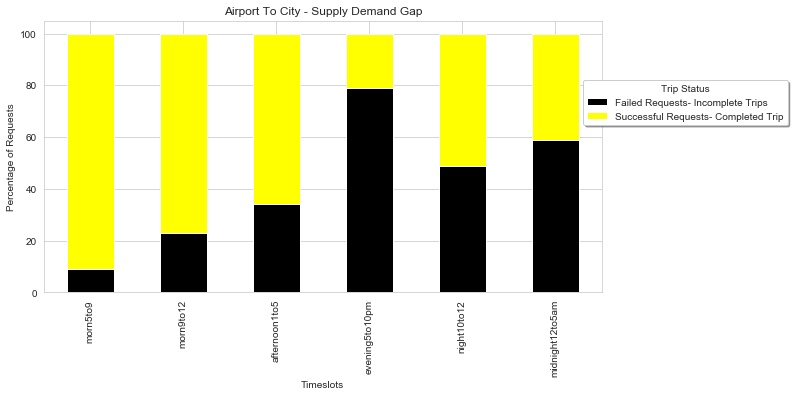

In [122]:
supply_dem_gap[["%Failed_req", "%TripCompleted"]].plot(kind='bar', stacked = True, figsize=[10,5], colormap='gnuplot')
plt.xlabel("Timeslots")
plt.ylabel("Percentage of Requests")
plt.title("Airport To City - Supply Demand Gap")
plt.legend(title = "Trip Status", labels = ['Failed Requests- Incomplete Trips', 'Successful Requests- Completed Trip'], loc='upper center', bbox_to_anchor=(1.15,0.8), shadow=True, ncol=1)

In [123]:
supply_dem_gap

,%Failed_req,%NoCarsAvail,%TripCompleted,%cancelled,Cancelled,No Cars Available,Trip Completed,failed requests,total_requests
morn5to9,9.0,4.0,91.0,4.0,15.0,14.0,308.0,29.0,337.0
morn9to12,23.0,13.0,77.0,10.0,22.0,30.0,176.0,52.0,228.0
afternoon1to5,34.0,19.0,66.0,15.0,50.0,64.0,225.0,114.0,339.0
evening5to10pm,79.0,73.0,21.0,6.0,106.0,1321.0,373.0,1427.0,1800.0
night10to12,49.0,48.0,51.0,1.0,3.0,136.0,142.0,139.0,281.0
midnight12to5am,59.0,58.0,41.0,1.0,2.0,148.0,103.0,150.0,253.0


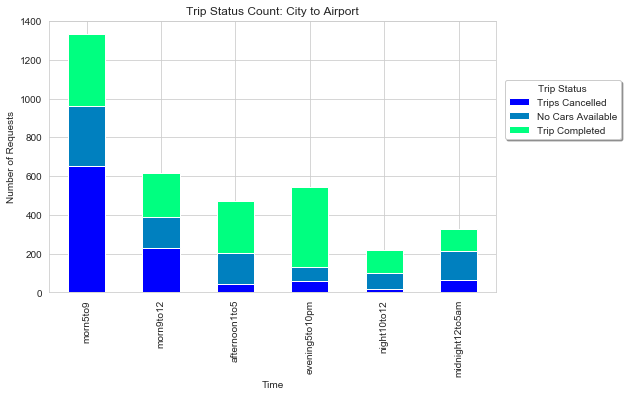

In [124]:
# Trip Status Count - Time Slots - City to Airport
morn5to9=pd.DataFrame(citysupdemgap.loc[5:8].sum())
morn9to12=pd.DataFrame(citysupdemgap.loc[9:11].sum())
afternoon1to5=pd.DataFrame(citysupdemgap.loc[12:16].sum())
evening5to10pm=pd.DataFrame(citysupdemgap.loc[17:21].sum())
night10to12=pd.DataFrame(citysupdemgap.loc[22:23].sum())
midnight12to5am=pd.DataFrame(citysupdemgap.loc[0:4].sum())

slots=pd.concat([morn5to9,morn9to12,afternoon1to5,evening5to10pm,night10to12,midnight12to5am],axis=1)

slots.columns=["morn5to9","morn9to12","afternoon1to5","evening5to10pm","night10to12","midnight12to5am"]
slots.reset_index(inplace=True)
slots.drop("level_0",axis=1,inplace=True)

slots.set_index("Status",inplace=True)
gap=slots.T
gap.plot(kind='bar', stacked=True, figsize=[8,5], colormap="winter")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.title("Trip Status Count: City to Airport")
plt.legend(title='Trip Status', labels=['Trips Cancelled', 'No Cars Available', 'Trip Completed'],
        loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)

### 하루 동안 "Airport to City" 공급 수요 격차는 평균 59 %
- 1.1 수요 공급이 가장 일반적인 요인?
    - "Non availability of cars". 
- 1.2 가장 문제였던 시간대는?
  - evening5to10, 79% unsuccessful trips being 73% due to non availability of cars

### 하루 동안 "City to Airport" 공급 수요 격차는 평균 57 %
- 2.1 원인 - 드라이버에 의한 취소로 인해 -30 %, "차량을 이용할 수 없음"으로 인해 27 %
- 2.2 가장 문제가되는 시간대:
    - 오전5시~9시, 취소로 인해 발생한 실패한 여행(49%), 가용한 자동차가 없는 이유로 23%
    - midnight12to5, 자동차를 이용할 수 없어서 46% 의 여행 실패..
    
### Conclusions after EDA:

- 아침 0500-0900hrs, 도시에서 공항으로의 높은 공급 수요 격차는 서비스가 제공되지 않는 자동차 때문이 아니라 가능한 경우에도 운전자가 요청을 취소하고 있음
- 오전 5시에 약 350 건의 요청이 도시에서 왔으며 100 건만 완료
- 동일한 기간 동안 85 건의 요청이 공항에서 완료되었다는 사실에서 명백한 다른 알려지지 않은 이유가 있을 것!
- 총 300 대의 자동차 300 개의 고유 한 운전자 ID, 즉 총 300 대의 자동차가 있으며 모든 픽업 팟에서 한 번에 최대 요청 수가 1800 시간에 500 회 기록





### 가능한 액션 플랜

- 늦은 저녁에 수요가 500대로 높아 지므로 더 많은 자동차를 제공합니다.
- 서비스를 위해 총 300 대의 자동차가있는 경우에도 120-170 건의 요청 만 완료된다는 사실에서 알 수 있듯이 고객에게 서비스를 제공하지 않는 자동차 문제를 해결
- 이른 아침, 운전자가 도시 요청을 대량으로 취소하는 것도 해결해야합니다. 자동차가 운행 중이 아닌 모든 가능한 원인을 찾아야하며, 요청에 비해 자동차 수가 훨씬 많은 경우에도 공급 수요 격차가없는 시간은 없습니다. 이 문제는 취소 원인에 대한 운전자의 피드백과 수요가 많은 시간에 작업에 사용할 수없는 문제로 해결 될 수 있습니다.